# Model 2 (VGG16)

In [40]:
# Necessary Imports

import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

In [41]:
import shutil
import os
import random

# Path to the main "digits" folder
main_folder = "../Working_Files"

# Copy the entire "digits" folder to the working directory
# shutil.copytree("/kaggle/input/digits", main_folder)             

# Create "test" and "train" folders
os.makedirs(os.path.join(main_folder, "test"), exist_ok=True)
os.makedirs(os.path.join(main_folder, "train"), exist_ok=True)

In [42]:
# Split ratio for test/train data
test_ratio = 0.1  # 10%

# Iterate over subfolders (0 to 9)
for i in range(10):
    subfolder_path = os.path.join(main_folder, "digits_jpeg", str(i))
    filenames = os.listdir(subfolder_path)
    random.shuffle(filenames)
    
    # Split the filenames into train and test sets
    test_size = int(len(filenames) * test_ratio)
    test_set = filenames[:test_size]
    train_set = filenames[test_size:]

    # Create subfolders for the current digit in the "test" and "train" folders
    os.makedirs(os.path.join(main_folder, "test", str(i)), exist_ok=True)
    os.makedirs(os.path.join(main_folder, "train", str(i)), exist_ok=True)

    # Move files to "test" folder
    for filename in test_set:
        src = os.path.join(subfolder_path, filename)
        dst = os.path.join(main_folder, "test", str(i), filename)
        shutil.move(src, dst)

    # Move files to "train" folder
    for filename in train_set:
        src = os.path.join(subfolder_path, filename)
        dst = os.path.join(main_folder, "train", str(i), filename)
        shutil.move(src, dst)

In [43]:
# Path to the train folder
train_folder = '../Working_Files/train'

# Get the list of directories (digit labels)
train_directories = os.listdir(train_folder)

# Create a dictionary mapping directory name to digit label
dict_labels = {folder_name: int(folder_name) for folder_name in train_directories}

print(dict_labels)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [44]:
def dataset(path):
    images = []
    labels = []
    failed_images = []

    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            
            image = cv2.imread(path_of_file)
            if image is None:
                raise Exception(f"Failed to load image: {path_of_file}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(value_of_label)
          

    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('../Working_Files/train')
images, labels = shuffle(images, labels)

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


In [45]:
print(images.shape)
print(labels.shape)

(9150, 224, 224, 3)
(9150,)


In [46]:
# Calculate the number of images for each digit

no_of_digits = []
for i in range(10):
    digit_folder = os.path.join('../Working_Files/train', str(i))
    no_of_images = len(os.listdir(digit_folder))
    print(i, " : ", no_of_images)

0  :  915
1  :  915
2  :  915
3  :  915
4  :  915
5  :  915
6  :  915
7  :  915
8  :  915
9  :  915


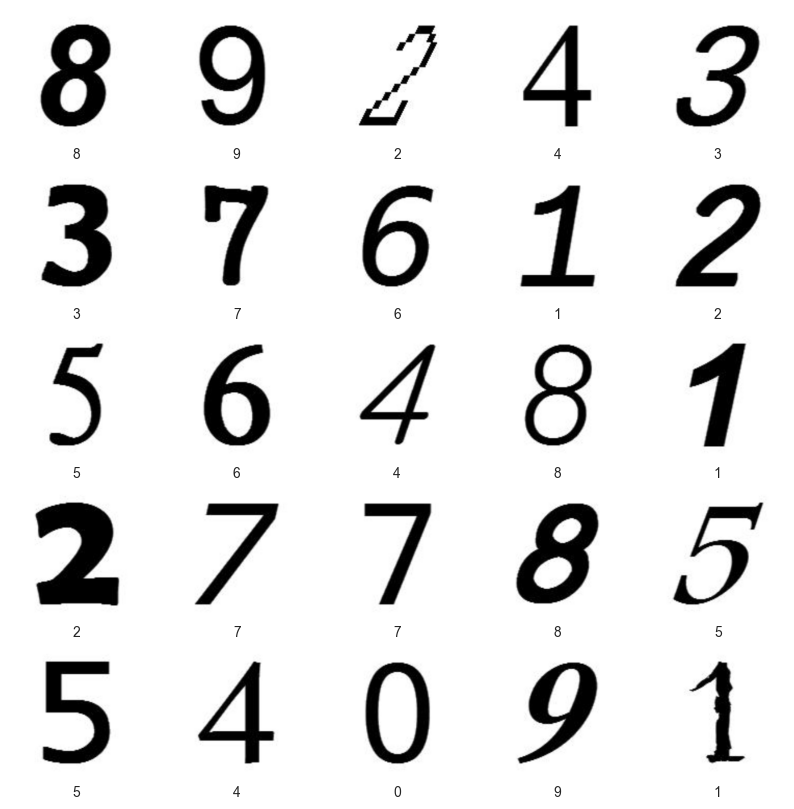

In [47]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(str(labels[i]))
plt.show()

In [48]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Define the batch size
batch_size = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training and test sets
train_generator = train_datagen.flow_from_directory(
    '../Working_Files/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '../Working_Files/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9150 images belonging to 10 classes.
Found 1010 images belonging to 10 classes.


In [49]:
from keras.src.applications.vgg16 import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (224,224,3)
)
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [50]:
from keras import Sequential
from keras.src.layers import Dropout, Flatten, Dense

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(10,activation='softmax'))
# model.summary()

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,epochs=15,validation_data=test_generator)

Epoch 1/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.6825 - loss: 0.9382 - val_accuracy: 0.9851 - val_loss: 0.0542
Epoch 2/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9588 - loss: 0.1367 - val_accuracy: 0.9921 - val_loss: 0.0249
Epoch 3/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9707 - loss: 0.0947 - val_accuracy: 0.9921 - val_loss: 0.0248
Epoch 4/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.9748 - loss: 0.0829 - val_accuracy: 0.9931 - val_loss: 0.0223
Epoch 5/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9763 - loss: 0.0746 - val_accuracy: 0.9931 - val_loss: 0.0253
Epoch 6/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9798 - loss: 0.0587 - val_accuracy: 0.9950 - val_loss: 0.0197
Epoch 7/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9865 - loss: 0.0442 - val_accuracy: 0.9921 - val_loss: 0.0242
Epoch 8/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.9832 - loss: 0.0492 - val_accu

In [ ]:
model.save('model_2.h5')